Warning message:
“Removed 7 rows containing missing values (geom_path).”

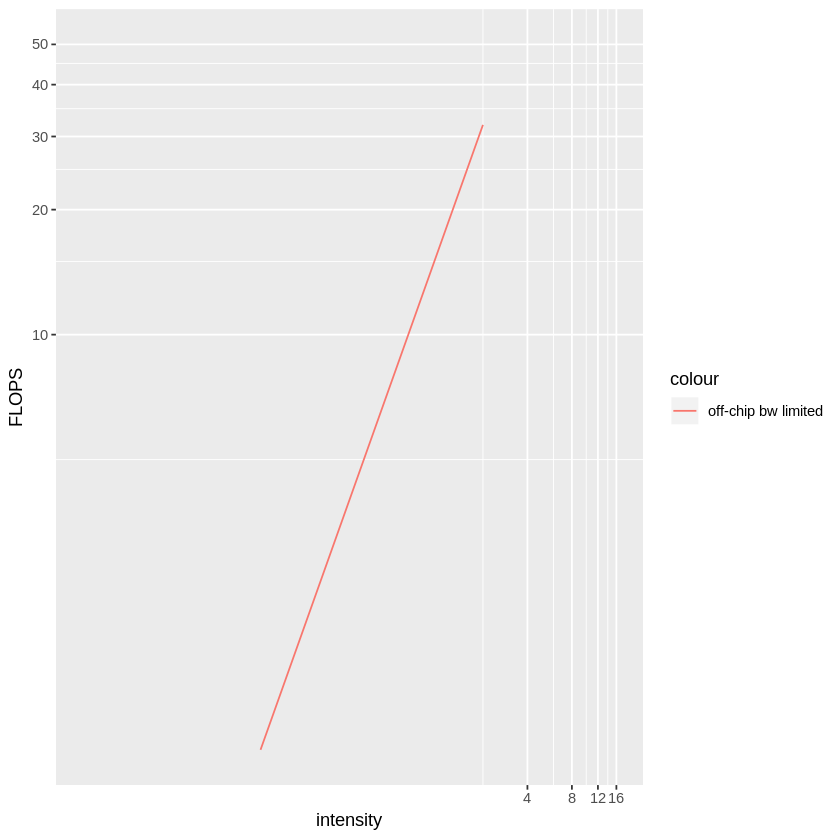

In [18]:
library(ggplot2)


intensity = 2^(-8:4)

flopsmax = 16 # GB/s
        
memband <- data.frame(intensity, intensity * 16 )
colnames(memband) <- c("intesnity","FLOPS")

aplot <- ggplot(memband, aes(x=intensity, y=FLOPS, color="off-chip bw limited")) +
          geom_line() + coord_trans(x="log2", y="log2") + scale_y_continuous(limits=c(1,50))
print(aplot)

